In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mypython.DataProcessing import *
import time
import seaborn as sns
import IPython.display as display
import os
from mypython import MLmodel, Treemodel, Linearmodel
import sklearn
import lightgbm
from mypython import PurgedGroupTimeSeriesSplit as tss
import warnings
warnings.filterwarnings("ignore")

# x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
# path_dict = {"asset_pool_path":"/sda/intern_data_shuofu/industry_1070.csv",
#             "feature_path": "/home/qianshuofu/factor_qianshuofu/Data/30_minutes_data.feather"}
# df_asset_pool = pd.read_csv(path_dict['asset_pool_path'])
# df_feature = FeatureDataFrame(pd.read_feather(path_dict["feature_path"])).filter_asset(df_asset_pool)



1004


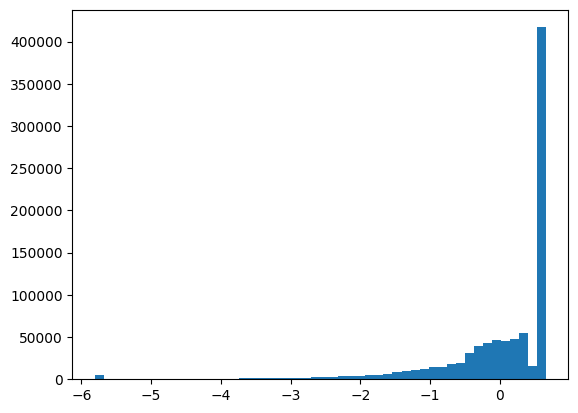

In [80]:
# 观察1000个特征的分布
df_feature = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')

for i in range(df_feature.shape[1]):
    print(i)
    plt.hist(df_feature[:,i],bins=50)
    plt.show()
    pause = input()
    # os.system("pause")
    display.clear_output(wait=True)

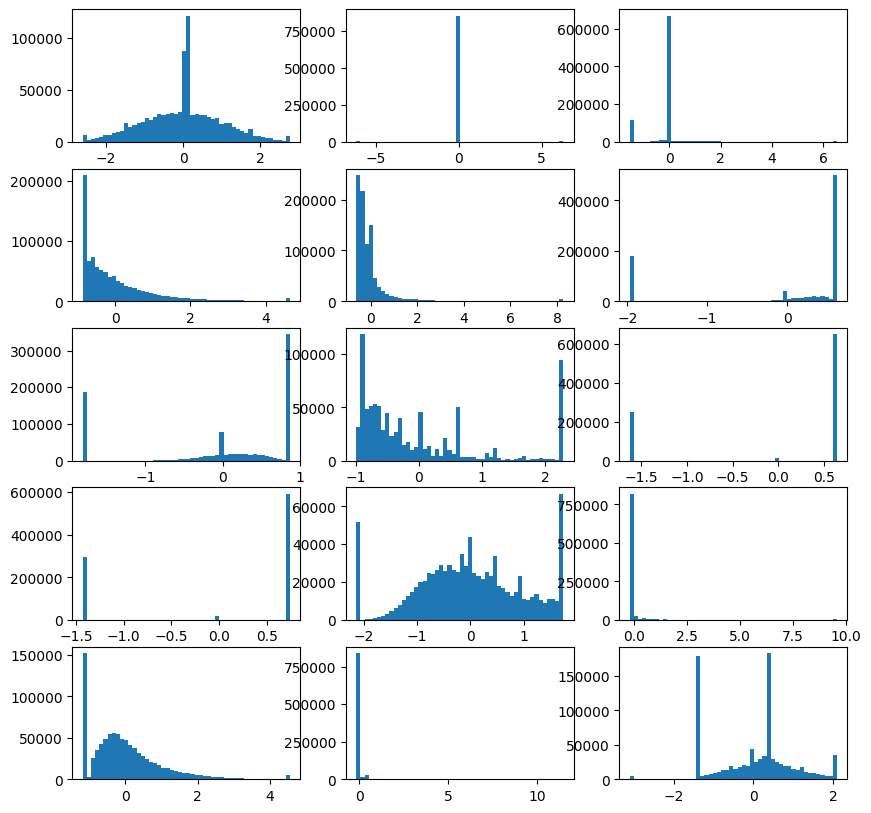

In [84]:
# 几种比较奇怪的分布的代表
df_feature = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')

list = [0,128,271,14,199,46,54,266,396,413,548,79,247,539,872]

#  0,128,271 中间有一列特别突出 
#  14 199 单调递减分布
#  46,54,266,396,413,548 奇怪的二项分布
#  79 因子值全部相同
#  247 奇怪的最小值和中间正态
#  539 单峰
#  872 中间双峰

fig = plt.figure(figsize=(10,10))

for i in range(len(list)):
    ax = fig.add_subplot(5,3,i+1)
    ax.hist(df_feature[:,list[i]],bins=50)

plt.show()

In [2]:
# 最原始数据看na和0值
df = pd.read_feather('/home/qianshuofu/factor_qianshuofu/Data/30_minutes_data.feather').iloc[:,2:]

pd.set_option('display.max_rows',None)

cm = sns.light_palette("orange", as_cmap=True)
df_na = pd.DataFrame({'feature':df.columns,'unique':df.nunique(),'na':df.isna().sum()/len(df),'0':(df==0).sum()/len(df)})
df_na['total'] = df_na['na']+df_na['0']
df_na = df_na.reset_index(drop=True)
df_na.style.background_gradient(cmap=cm,subset=['na', '0','total'])

,feature,unique,na,0,total
0,up_over_down_for_vol,822110,0.000000,0.200868,0.200868
1,trace,2877757,0.000000,0.174461,0.174461
2,price_volume_corr_min,6806354,0.000000,0.104886,0.104886
3,sharpe_min,3651267,0.000000,0.324676,0.324676
4,high_minus_low_volume_corr_min,3941113,0.000000,0.396490,0.396490
5,quantile_vol_rate_90_10,166693,0.000000,0.267473,0.267473
6,quantile_vol_rate_80_20,145008,0.000000,0.396897,0.396897
7,quantile_vol_sum_90,20660,0.000000,0.080418,0.080418
8,quantile_vol_sum_10,2863,0.000000,0.889076,0.889076
9,quantile_vol_sum_80,25888,0.000000,0.072504,0.072504


In [7]:
# 能不能把不好的列删掉,问题是:添加新的特征一定会使模型更好吗? 观察下之前模型的特征重要性
# 卷积神经网络里加深度会导致模型变差 然后就是用残差网络解决的 但lgihtgbm本身拟合的就是残差了哎

# 一个猜想: 其实每个特征划分的能力都不是很强 导致划分后的两个叶子完全是原叶子分布的缩小版 他们的均值还是原来的均值 所以最后模型预测全都拿0来猜了

x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load("/home/qianshuofu/factor_qianshuofu/Data/data_label.npy")

x_train, x_test,  y_train, y_test  = sklearn.model_selection.train_test_split(x,y,test_size=0.3,random_state=42)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_train,y_train,test_size=0.1,random_state=42)

# model = lightgbm.train({},lightgbm.Dataset(x_train,y_train),valid_sets=lightgbm.Dataset(x_train,y_train),verbose_eval=1)
# model = lightgbm.train({},lightgbm.Dataset(x_train,y_train),verbose_eval=1)
model = lightgbm.sklearn.LGBMRegressor(n_estimators=500).fit(x_train,y_train,eval_set=[(x_valid,y_valid)],early_stopping_rounds=50) #eval_metric=['l2','l1']

y_pred = model.predict(x_test)

print(sklearn.metrics.mean_squared_error(y_test,y_pred))
print(np.corrcoef(y_pred.argsort().argsort(),y_test.argsort().argsort()))


# column = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_column.npy',allow_pickle=True)[2:-1]
# df_impor = pd.DataFrame({'feature':column,'importance':model.booster_.feature_importance()})
# df_impor['feature'] = df_impor.feature.apply(lambda x: str(x)[:-9])
# df_impor = df_impor.groupby(['feature']).mean().reset_index()

# df_result = pd.merge(df_impor,df_na,on=['feature']).sort_values(by=['importance'],ascending=False).reset_index(drop=True).style.background_gradient(cmap=cm,subset=['na', '0','total'])
# df_result

/home/qianshuofu/anaconda3/envs/rapids-22.12/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.967332
[2]	valid_0's l2: 0.965853
[3]	valid_0's l2: 0.964551
[4]	valid_0's l2: 0.963437
[5]	valid_0's l2: 0.962317
[6]	valid_0's l2: 0.961508
[7]	valid_0's l2: 0.960841
[8]	valid_0's l2: 0.960245
[9]	valid_0's l2: 0.959899
[10]	valid_0's l2: 0.959187
[11]	valid_0's l2: 0.958907
[12]	valid_0's l2: 0.95829
[13]	valid_0's l2: 0.957829
[14]	valid_0's l2: 0.957486
[15]	valid_0's l2: 0.957146
[16]	valid_0's l2: 0.956823
[17]	valid_0's l2: 0.956752
[18]	valid_0's l2: 0.956494
[19]	valid_0's l2: 0.956352
[20]	valid_0's l2: 0.956027
[21]	valid_0's l2: 0.955693
[22]	valid_0's l2: 0.955421
[23]	valid_0's l2: 0.955086
[24]	valid_0's l2: 0.954829
[25]	valid_0's l2: 0.954584
[26]	valid_0's l2: 0.954473
[27]	valid_0's l2: 0.954255
[28]	valid_0's l2: 0.954042
[29]	valid_0's l2: 0.953828
[30]	valid_0's l2: 0.953583
[31]	valid_0's l2: 0.953349
[32]	valid_0's l2: 0.953181
[33]	valid_0's l2: 0.952905
[34]	valid_0's l2: 0.952778
[35]	valid_0's l2: 0.952862
[36]	valid_0's l2: 0.952616
[3

,feature,importance,unique,na,0,total
0,Bar_AverageAmountReturn_Log,37.555556,5100599,0.096357,0.242834,0.339191
1,price_volume_corr_min,31.333333,6806354,0.000000,0.104886,0.104886
2,high_vol_ret,29.111111,3899661,0.000000,0.000000,0.000000
3,ret_index_corr_allday,27.333333,7011082,0.174461,0.000000,0.174461
4,trace,25.444444,2877757,0.000000,0.174461,0.174461
5,ApT_inFlow_ratio,22.444444,4746431,0.000000,0.271385,0.271385
6,sharpe_min,22.333333,3651267,0.000000,0.324676,0.324676
7,ret_down_std,21.777778,2016729,0.663733,0.026041,0.689773
8,Bar_AverageAmountReturn,21.666667,5121831,0.024941,0.314248,0.339188
9,PriceShapeDev_intra_maxdrawdown_20,20.666667,67085,0.000000,0.527615,0.527615


In [18]:
# 尝试一下把差的特征全都删去
# 事实证明把重要性差的特征去掉并没有什么改变 是不是说明问题还是前面的特征分类效果太差了

x2 = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y2 = np.load("/home/qianshuofu/factor_qianshuofu/Data/data_label.npy")
# y2 = y2.argsort().argsort()/len(y2)

# feature_new = np.where(model.booster_.feature_importance() >= 10)[0]
# x2 = x2[:,feature_new]

x_train2, x_test2,  y_train2, y_test2  = sklearn.model_selection.train_test_split(x2,y2,test_size=0.3,random_state=42)
x_train2, x_valid2, y_train2, y_valid2 = sklearn.model_selection.train_test_split(x_train2,y_train2,test_size=0.1,random_state=42)

model2 = lightgbm.sklearn.LGBMRegressor(n_estimators=500).fit(x_train2,y_train2,eval_set=[(x_valid2,y_valid2)],early_stopping_rounds=50) #eval_metric=['l2','l1']
y_pred2 = model2.predict(x_test2)

print(sklearn.metrics.mean_squared_error(y_test2,y_pred2))
print(np.corrcoef(y_pred2.argsort().argsort(),y_test2.argsort().argsort()))

/home/qianshuofu/anaconda3/envs/rapids-22.12/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.967332
[2]	valid_0's l2: 0.965853
[3]	valid_0's l2: 0.964551
[4]	valid_0's l2: 0.963437
[5]	valid_0's l2: 0.962317
[6]	valid_0's l2: 0.961508
[7]	valid_0's l2: 0.960841
[8]	valid_0's l2: 0.960245
[9]	valid_0's l2: 0.959899
[10]	valid_0's l2: 0.959187
[11]	valid_0's l2: 0.958907
[12]	valid_0's l2: 0.95829
[13]	valid_0's l2: 0.957829
[14]	valid_0's l2: 0.957486
[15]	valid_0's l2: 0.957146
[16]	valid_0's l2: 0.956823
[17]	valid_0's l2: 0.956752
[18]	valid_0's l2: 0.956494
[19]	valid_0's l2: 0.956352
[20]	valid_0's l2: 0.956027
[21]	valid_0's l2: 0.955693
[22]	valid_0's l2: 0.955421
[23]	valid_0's l2: 0.955086
[24]	valid_0's l2: 0.954829
[25]	valid_0's l2: 0.954584
[26]	valid_0's l2: 0.954473
[27]	valid_0's l2: 0.954255
[28]	valid_0's l2: 0.954042
[29]	valid_0's l2: 0.953828
[30]	valid_0's l2: 0.953583
[31]	valid_0's l2: 0.953349
[32]	valid_0's l2: 0.953181
[33]	valid_0's l2: 0.952905
[34]	valid_0's l2: 0.952778
[35]	valid_0's l2: 0.952862
[36]	valid_0's l2: 0.952616
[3

In [ ]:
# 疑惑:
# - 为什么像high_vol_vwap_80这种取对数后看起来不错的特征重要性为0
# plt.hist(np.log(df['high_vol_vwap_80']),bins=50)

# 解决计划:
# - 先删掉全部都为0的列
# - na处理: 每只股票内部按时序排列,改为用上下均值填充na, 之后仍为na的按该列所有股票的平均值填充,观察效果
# - 0值过多问题: ???


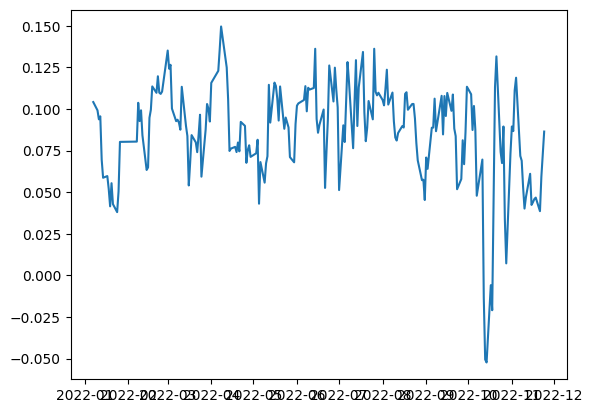

In [97]:
# 检查一下IC到底是多少
# 如果训练集测试集随机划分能0.12 但如果按2022年之前和之后划分只有0.068
# 按时间划分之后ic的五步平均如下

df_index = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_index.npy',allow_pickle=True)
begin_index = 699857

x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load("/home/qianshuofu/factor_qianshuofu/Data/data_label.npy")

x_train, x_test,  y_train, y_test  = x[:begin_index], x[begin_index:], y[:begin_index], y[begin_index:]
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_train,y_train,test_size=0.1,random_state=42)

model = lightgbm.sklearn.LGBMRegressor(n_estimators=500).fit(x_train,y_train,eval_set=[(x_valid,y_valid)],early_stopping_rounds=50) #eval_metric=['l2','l1']
y_pred = model.predict(x_test)

print(sklearn.metrics.mean_squared_error(y_test,y_pred))
print(np.corrcoef(y_pred.argsort().argsort(),y_test.argsort().argsort()))

# 绘图
df_ic = pd.DataFrame({'datetime':df_index[begin_index:,1],'y_true':y_test,'y_pred':y_pred}) #'code':df_index[begin_index:,0],
df_ic['datetime'] = pd.to_datetime(df_ic['datetime'])
ic = df_ic.groupby(['datetime']).apply(lambda x: np.corrcoef(x['y_true'].argsort().argsort(),x['y_pred'].argsort().argsort())[0,1])
plt.plot(ic.rolling(5,center=False).mean())

<Axes: title={'center': 'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

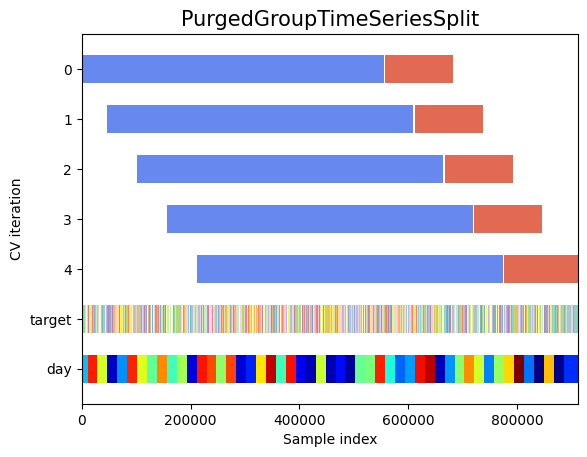

In [3]:
x = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_feature.npy')
y = np.load('/home/qianshuofu/factor_qianshuofu/Data/data_label.npy')

fig, ax = plt.subplots()
cv = tss.PurgedGroupTimeSeriesSplit(group_gap=1)
tss.plot_cv_indices(cv, x, y, ax, lw=20)